# Apple Stock prediction

## Introduction 

A time series describes how a variable is changing along time. Time is considered as a crucial factor in not only natural processes but also in the business world. Among them, here I will talk about the stock market. The motivation of mine for this post is first to get a better understanding of predictive models in time series analysis and second get myself familiar with the stock market. I will go into analyzing daily changes in Apple stock and will look at how we can predict it using more efficient Machine Learning methods for time series such as Autoregressive Integrated Moving Average (ARIMA) and Long Short Term Memory(LSTM). Although I take the stock market as a case study here, these methods are popular and quite applicable to most of the time series related modelling.

The workflow will be as follows:
1. A basic analysis of the Apple stock data
2. implemntation of the ARIMA model
3. Implematation of the LSTM model


In [69]:
#Importing Libraries
import pandas as pd # data processing
import numpy as np # linear algebra
import seaborn as sns # Plotting
#import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
#" %matplotlib inline " makes life easy by returning output plots without needing to write plt.show() code everytime after each plot!
#Loading dataset

import matplotlib

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
import pylab as pl
from pylab import rcParams
from matplotlib import cm
import matplotlib.dates as mdates
import datetime as dt
import plotly.graph_objs as go
import plotly.offline as py
import os
import plotly.tools as tls
import plotly.figure_factory as ff
import matplotlib.ticker as mtick


In [70]:
df = pd.read_csv('/Users/hossein/Stock_Market/AAPL.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.023007,117258400.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.021807,43971200.0
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.020206,26432000.0
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.020706,21610400.0
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.021307,18362400.0


## A basic analysis of the Apple stock data

In [71]:
ndayforward = 2
df['daily_change'] = df['Close'].pct_change()*100
df['n_day_after_change'] = df['daily_change'].shift(-ndayforward)

In [72]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,daily_change,n_day_after_change
Date,,,,,,,,
2019-02-04,167.410004,171.660004,167.279999,171.250000,170.518677,31495500.0,2.840497,0.034454
2019-02-05,172.860001,175.080002,172.350006,174.179993,173.436157,36101600.0,1.710945,-1.893941
2019-02-06,174.649994,175.570007,172.850006,174.240005,173.495911,28239600.0,0.034454,-0.310049
2019-02-07,172.399994,173.940002,170.339996,170.940002,170.210007,31741700.0,-1.893941,NaN
2019-02-08,168.990005,170.660004,168.419998,170.410004,170.410004,23802100.0,-0.310049,NaN


In [73]:
dcriteria = (df.index >= '1980-12-12') & (df.index <= dt.datetime.today())
tcriteria = (df['daily_change'] < -1)
criteria = dcriteria & tcriteria

             

In [75]:
df[criteria].loc[:,['Close', 'daily_change', 'n_day_after_change']].agg(['mean', 'std','median'])

,Close,daily_change,n_day_after_change
mean,17.076717,-2.844486,0.216660
std,38.033417,2.186061,3.323006
median,1.486607,-2.272710,0.088181


In [76]:
# convert string to datetime64[ns] format
#df["Date"] = pd.to_datetime(df["Date"])

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9622 entries, 1980-12-12 to 2019-02-08
Data columns (total 8 columns):
Open                  9621 non-null float64
High                  9621 non-null float64
Low                   9621 non-null float64
Close                 9621 non-null float64
Adj Close             9621 non-null float64
Volume                9621 non-null float64
daily_change          9621 non-null float64
n_day_after_change    9620 non-null float64
dtypes: float64(8)
memory usage: 676.5 KB


In [78]:
df.corr()

,Open,High,Low,Close,Adj Close,Volume,daily_change,n_day_after_change
Open,1.000000,0.999956,0.999940,0.999896,0.993535,-0.088813,-0.004692,-0.007220
High,0.999956,1.000000,0.999927,0.999949,0.993575,-0.087667,-0.003106,-0.007239
Low,0.999940,0.999927,1.000000,0.999952,0.993692,-0.090762,-0.002610,-0.007340
Close,0.999896,0.999949,0.999952,1.000000,0.993682,-0.089217,-0.000857,-0.007333
Adj Close,0.993535,0.993575,0.993692,0.993682,1.000000,-0.123695,-0.001681,-0.007108
Volume,-0.088813,-0.087667,-0.090762,-0.089217,-0.123695,1.000000,0.002315,-0.009341
daily_change,-0.004692,-0.003106,-0.002610,-0.000857,-0.001681,0.002315,1.000000,-0.028263
n_day_after_change,-0.007220,-0.007239,-0.007340,-0.007333,-0.007108,-0.009341,-0.028263,1.000000


In [79]:
#x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df.Date]
#new_x = matplotlib.dates.datestr2num(df.Date)

In [ ]:
#Create a new column. The column writes 'rise' for  values higher than average otherwise writes'fall'
Close_mean = df.Close.mean()  #calculate average
df["Close_level"] = ["rise" if Close_mean < each else "fall" for each in df.Close]  #values are scanned in high column
df.head()

## implemntation of the ARIMA model

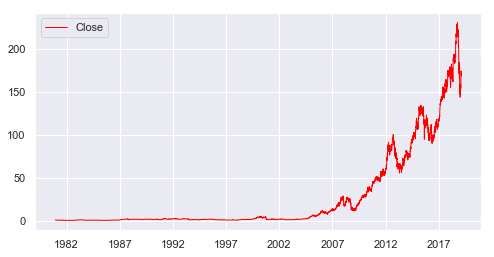

In [84]:
#since 1980
rcParams['figure.figsize'] = 8, 4
plt.plot(df.Open,marker='', color='red', linewidth=1, linestyle='solid', label="Close")
plt.legend()

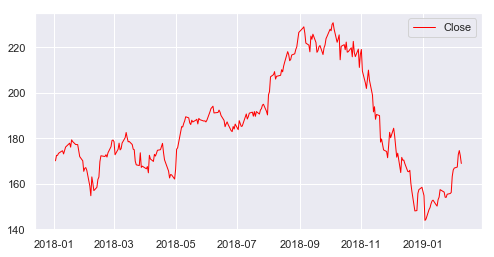

In [85]:
#since 2018-01 till now
rcParams['figure.figsize'] = 8, 4
plt.plot(df.Open["2018-01":],marker='', color='red', linewidth=1, linestyle='solid', label="Close")
plt.legend()

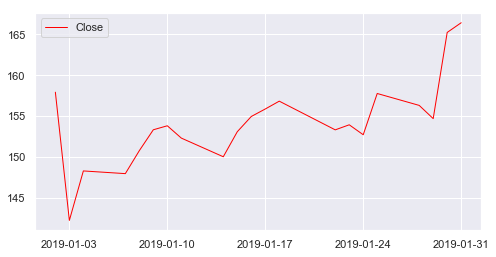

In [87]:
#for Jan 2019
rcParams['figure.figsize'] = 8, 4
plt.plot(df.Close["2019-01"],marker='', color='red', linewidth=1, linestyle='solid', label="Close")
plt.legend()


In [103]:
df.high_level.unique()

array(['fall', 'rise'], dtype=object)

In [89]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=1)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #print('Results of Dickey-Fuller Test:')
    #dftest = adfuller(timeseries, autolag='AIC')
    #dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    #for key,value in dftest[4].items():
    #    dfoutput['Critical Value (%s)'%key] = value
    #print(dfoutput,'%f' % (1/10**8))
 

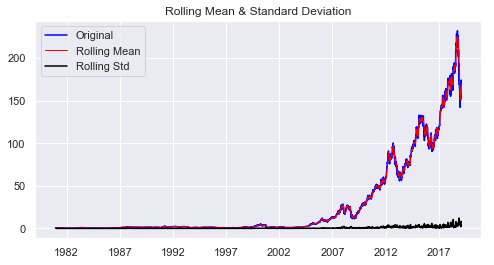

In [90]:
test_stationarity(df.Close)
#the variation in standard deviation is small but mean is increasing with time so we conclude that this is not a stationary series

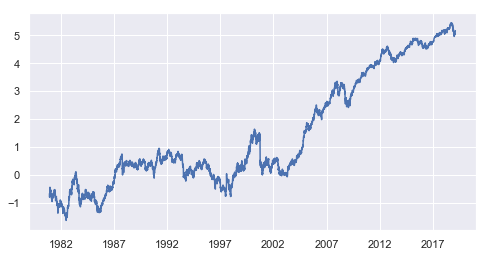

In [91]:
dfClose_log = np.log(df.Close)
plt.plot(dfClose_log)

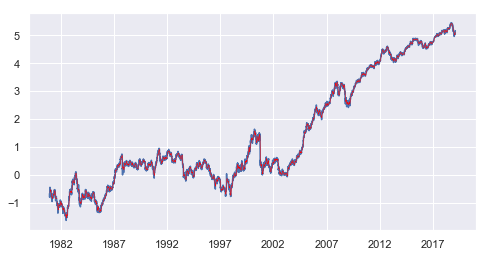

In [92]:
moving_avg = dfClose_log.rolling(12).mean()
plt.plot(dfClose_log)
plt.plot(moving_avg, color='red', linewidth=0.5)

In [93]:
dfClose_log_moving_avg_diff = dfClose_log - moving_avg
dfClose_log_moving_avg_diff.head(12)

Date
1980-12-12         NaN
1980-12-15         NaN
1980-12-16         NaN
1980-12-17         NaN
1980-12-18         NaN
1980-12-19         NaN
1980-12-22         NaN
1980-12-23         NaN
1980-12-24         NaN
1980-12-26         NaN
1980-12-29         NaN
1980-12-30    0.160537
Name: Close, dtype: float64

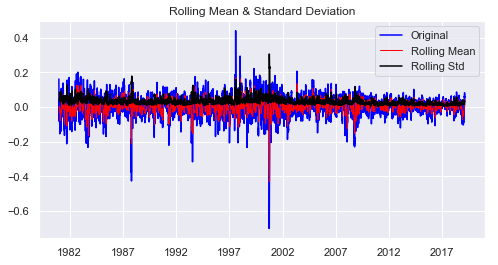

In [94]:
dfClose_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(dfClose_log_moving_avg_diff)

In [187]:
#pd.ewma(dfOpen_log, span=12, freq="D")

#ewma(dfOpen_log, span=60)

#expwighted_avg = ewma(dfOpen_log,halflife =12)
#dfOpen_log.ewm(span=10, min_periods=10,axis=0)



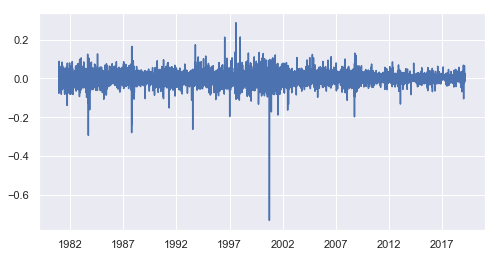

In [95]:
dfClose_log_diff = dfClose_log - dfClose_log.shift()
plt.plot(dfClose_log_diff)

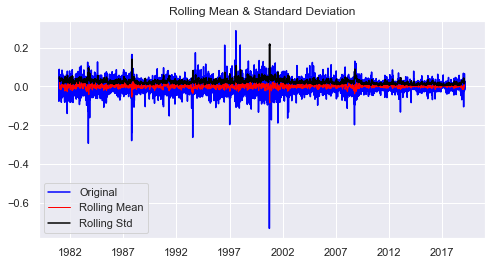

In [96]:
dfClose_log_diff.dropna(inplace=True)
test_stationarity(dfClose_log_diff)

In [97]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [98]:
lag_acf = acf(dfClose_log_diff["2017":"2018"], nlags=20)
lag_pacf = pacf(dfClose_log_diff["2017":"2018"], nlags=20, method='ols')

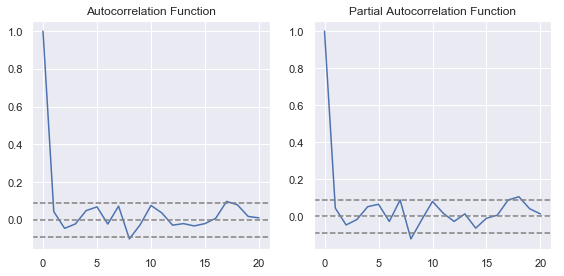

In [100]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dfClose_log_diff["2017":"2018"])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dfClose_log_diff["2017":"2018"])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dfClose_log_diff["2017":"2018"])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dfClose_log_diff["2017":"2018"])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [101]:
from statsmodels.tsa.arima_model import ARIMA

/Users/hossein/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/hossein/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Text(0.5,1,'RSS: nan')

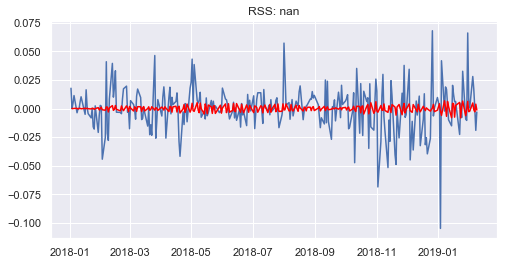

In [102]:
model = ARIMA(dfClose_log["2018":"2019"], order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(dfClose_log_diff["2018":"2019"])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-dfClose_log_diff)**2))

In [103]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
2018-01-03   -0.000045
2018-01-04   -0.000048
2018-01-05    0.000077
2018-01-08    0.000123
2018-01-09   -0.000434
dtype: float64


In [105]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Date
2018-01-03   -0.000045
2018-01-04   -0.000093
2018-01-05   -0.000017
2018-01-08    0.000107
2018-01-09   -0.000327
dtype: float64


In [106]:
predictions_ARIMA_log = pd.Series(dfClose_log["2018":"2019"].iloc[0], index=dfClose_log["2018":"2019"].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2018-01-02    5.149005
2018-01-03    5.148960
2018-01-04    5.148912
2018-01-05    5.148988
2018-01-08    5.149112
dtype: float64

Text(0.5,1,'RMSE: nan')

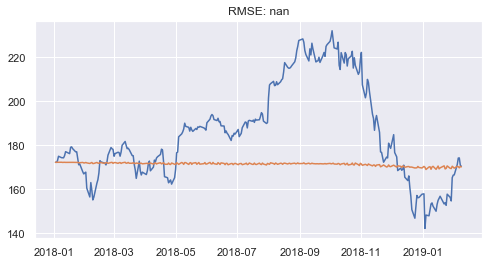

In [107]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df.Close["2018":"2019"])
plt.plot(predictions_ARIMA["2018":"2019"])
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df.Close)**2)/len(df.Close)))

## Implematation of the LSTM model

In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


In [2]:
df = pd.read_csv('/Users/hossein/Stock_Market/AAPL.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.023007,117258400.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.021807,43971200.0
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.020206,26432000.0
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.020706,21610400.0
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.021307,18362400.0


In [3]:
# line plot
df["Close"].plot()


In [4]:
df_close = df['Close'].iloc[-50:]

In [5]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [6]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [7]:
# transform data to be stationary
raw_values = df_close.values
diff_values = difference(raw_values, 1)

In [8]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [9]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [10]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [11]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[ 0.3133918 ],
       [-0.14030881],
       [ 0.03068881],
       [ 0.1165262 ],
       [-0.23187958],
       [ 0.1029043 ],
       [-0.03512679],
       [-0.03967018],
       [ 0.14277057],
       [ 0.20751801],
       [ 0.06621197],
       [ 0.01466194],
       [ 0.10748158],
       [ 0.21635218],
       [ 0.19074222],
       [ 0.15842378],
       [-0.20897548],
       [ 0.09839977],
       [ 0.8684861 ],
       [ 0.12804396],
       [ 0.4105109 ],
       [ 0.23868987],
       [-0.05343492],
       [ 0.03740855],
       [ 0.51102835],
       [-0.00607347],
       [ 0.06285718],
       [ 0.2162546 ],
       [ 0.10940494],
       [ 0.10302402],
       [ 0.245856  ],
       [ 0.5670679 ],
       [ 0.48599827],
       [ 0.34516025],
       [ 0.2896729 ],
       [ 0.21359773],
       [ 0.42968243]], dtype=float32)

In [12]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Day=1, Predicted=157.083924, Expected=152.699997
Day=2, Predicted=155.594509, Expected=157.759995
Day=3, Predicted=155.618155, Expected=156.300003
Day=4, Predicted=155.949378, Expected=154.679993
Day=5, Predicted=155.919009, Expected=165.250000
Day=6, Predicted=158.203240, Expected=166.440002
Day=7, Predicted=161.687996, Expected=166.520004
Day=8, Predicted=162.496841, Expected=171.250000
Day=9, Predicted=165.704237, Expected=174.179993
Day=10, Predicted=169.164946, Expected=174.240005
Day=11, Predicted=169.857685, Expected=170.940002
Day=12, Predicted=169.864951, Expected=170.410004


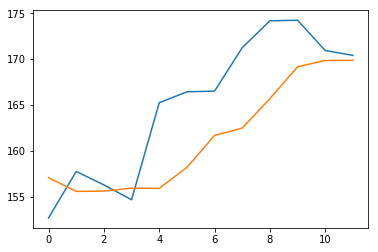

In [14]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()